In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True

name = "simdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [2]:
import torch
import string
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from mlutils.measures import corr

from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer
from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader

Connecting konstantin@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306
Schema name: konstantin_nnsysident_simdata


In [3]:
def get_transfer(old_experiment_name):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    transfer = pd.DataFrame(Transfer.fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    tm = pd.DataFrame((TrainedModel * Dataset * Seed * Experiments.Restrictions & 'experiment_name = "{}"'.format(old_experiment_name)).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_neuron_n', 't_image_n', 't_neuron_base_seed', 't_image_base_seed'])
    return transfer

def baseline(data, tier):
    """ Function to estimate the highest possible correlation based on the ground truth"""
    # get dataset
    for loc, row in data_.iterrows():
        dataset_config = row['dataset_config']
        dataset_config.update(seed=1)
        dataloaders = builder.get_data(row['dataset_fn'], dataset_config)
        dataset = dataloaders['train']['0-0-3-0'].dataset
        dataset.transforms = []
        break
    # Extract data
    idx = dataset.trial_info.tiers == tier
    gts = np.array([gt for gt in dataset.neurons.ground_truths]).T[idx]
    resps = np.array([datapoint.responses for datapoint in dataset])[idx]
    # Compute correlation and return
    return np.mean(corr(resps, gts, axis=0))

# Triple plot for sim data

In [4]:
# Direct
data = pd.DataFrame()
for experiment_name in ['SIM, Direct, se2d_spatialxfeaturelinear, 0-0-3', 'SIM, Direct, se2d_pointpooled, 0-0-3', 'SIM, Direct, se2d_fullgaussian2d, 0-0-3']:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore * Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})
direct_data = data.copy()
direct_data['Condition'] = "direct"
base_line = baseline(data=data, tier='test')

# Filter out best performing models over model seeds
direct_data = direct_data.sort_values('score', ascending=False).drop_duplicates(['Readout',
                                                                   '# neurons',
                                                                   '# images', 
                                                                   'neuron_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', '# neurons', '# images'])


# Full readout data
data = pd.DataFrame()
for experiment_name in ["SIM, core_transfer (sameNI), se2d_fullgaussian2d, 0-0-3 -> 0-0-3, readout full I",
                        "SIM, core_transfer (sameNI), se2d_pointpooled, 0-0-3 -> 0-0-3, readout full I",
                        "SIM, core_transfer (sameNI), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3, readout full I"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * OracleScoreTransfer * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer = get_transfer(old_experiment_name='SIM, Direct, {}, 0-0-3'.format(experiment_name.split(', ')[2]))
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = data.rename(columns = {'t_neuron_n': '# neurons', 't_image_n': "# images"})
full_readout_data = data.copy()
full_readout_data['Condition'] = "diff-core/best-readout"

# Full core data
data = pd.DataFrame()
for experiment_name in ["SIM, core_transfer (best), se2d_fullgaussian2d, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_pointpooled, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * OracleScoreTransfer * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer = get_transfer(old_experiment_name='SIM, Direct, {}, 0-0-3'.format(experiment_name.split(', ')[2]))
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})
full_core_data = data.copy()
full_core_data['Condition'] = "best-core/diff-readout"

# panel1 = pd.concat([direct_data, full_core_data])
# panel2 = pd.concat([direct_data, full_readout_data])
# panel3 = pd.concat([full_core_data, full_readout_data])
# panel1['panel'] = 'panel1'
# panel2['panel'] = 'panel2'
# panel3['panel'] = 'panel3'
# data = pd.concat([panel1, panel2, panel3])

data = pd.concat([direct_data, full_readout_data, full_core_data])
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point readout'}}, inplace=True)



data/static0-0-3-preproc0 exists already. Not unpacking data/static0-0-3-preproc0.zip


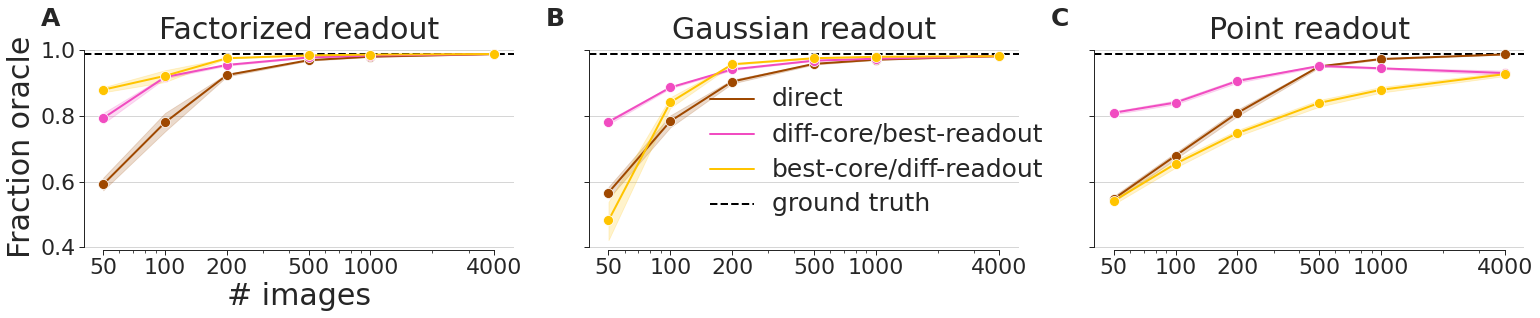

In [5]:
title = 'Simulated data triple plot'
scoring_measure = "fraction_oracle" 
sns.set_context("paper")        
col_order = ['Factorized readout', 'Gaussian readout', 'Point readout']
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,8) ]

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.5), sns.color_palette('bright'), sns.axes_style('ticks'):        
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Condition", 
                    col="Readout",
                    col_order=col_order,
                    kind="line",
                    marker="o",
                    data=data,
                   palette=palette,
                   aspect=0.88)          
    g.map(plt.axhline, y=base_line, c='k', ls='--', zorder=0, label= "ground truth")  
       
    g._legend.remove()
    g.add_legend()
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    g.axes[0,0].set_xlabel('# images')
    g.axes[0,1].set_xlabel('# images')
    g.axes[0,2].set_xlabel('# images')
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.57,.46,.1,.1))
    
    for label in g._legend.texts:
        label.set_size(25)
    
    for i, ax in enumerate(g.axes.flatten()): 
        ax.set_title(ax.get_title()[10:])
        ax.text(-0.1, 1.09, string.ascii_uppercase[i], transform=ax.transAxes, 
        size=25, weight='bold')    
        ax.yaxis.grid(True)
        ax.set_xscale('log')
        ax.set_xticks(np.unique(data['# images']))
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        
        ax.set_title(ax.get_title(), fontsize=30)
        
        if i > 0:
            ax.set(xlabel="")
        else:
            ax.set_xlabel("# images", fontsize=30)
            ax.set_ylabel("Fraction oracle", fontsize=30)
            
    sns.despine(trim=True)
    plt.tight_layout()
#     g.fig.savefig(title + '.pdf', dpi=150)

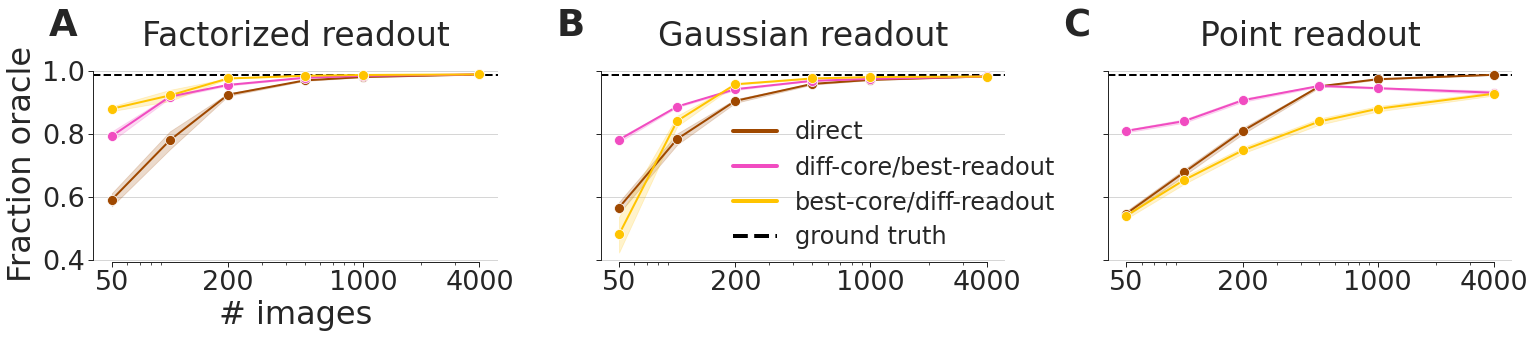

In [59]:
title = 'Simulated data triple plot'
scoring_measure = "fraction_oracle" 
sns.set_context("paper")        
col_order = ['Factorized readout', 'Gaussian readout', 'Point readout']
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,8) ]

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.5), sns.color_palette('bright'), sns.axes_style('ticks'):        
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Condition", 
                    col="Readout",
                    col_order=col_order,
                    kind="line",
                    marker="o",
                    data=data,
                    palette=palette,
                    height=5.4,
                    aspect=0.81)          
    g.map(plt.axhline, y=base_line, c='k', ls='--', zorder=0, label= "ground truth")  
       
    g._legend.remove()
    g.add_legend()
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    g.axes[0,0].set_xlabel('# images')
    g.axes[0,1].set_xlabel('# images')
    g.axes[0,2].set_xlabel('# images')
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.58, .39, .1, .1))
    
    for label in g._legend.texts:
        label.set_size(24)
    for h in g._legend.legendHandles[1:]:
        h.set_linewidth(4)
    
    for i, ax in enumerate(g.axes.flatten()): 
        ax.set_title(ax.get_title()[10:])
        ax.text(-0.11, 1.15, string.ascii_uppercase[i], transform=ax.transAxes, size=37, weight='bold')    
        ax.yaxis.grid(True)
        ax.set_xscale('log')
        ax.set_xticks(np.unique(data['# images'])[[0, 2, 4, 5]])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.tick_params(labelsize=27)
        
        ax.text(0.5, 1.1, ax.get_title(),
                horizontalalignment='center',
                fontsize=33,
                transform=ax.transAxes)
        ax.set_title("")
        
        if i > 0:
            ax.set(xlabel="")
        else:
            ax.set_xlabel("# images", fontsize=32)
            ax.set_ylabel("Fraction oracle", fontsize=32)
            
    sns.despine(trim=True)
    plt.tight_layout()
    g.fig.savefig(title + '.pdf', dpi=150, bbox_inches='tight')

In [ ]:
leg.h

In [ ]:
leg.set_title('A great legend',prop={'size':14})

### Directly trained

In [ ]:
data = pd.DataFrame()
for experiment_name in ['SIM, Direct, se2d_spatialxfeaturelinear, 0-0-3', 'SIM, Direct, se2d_pointpooled, 0-0-3', 'SIM, Direct, se2d_fullgaussian2d, 0-0-3']:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})

base_line = baseline(data=data, tier='validation')

In [ ]:
title = 'Directly trained'
scoring_measure = "score" #"fraction_oracle"
neuron_n = 1000

hues = np.unique(data.readout.values)

with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.pointplot('# images', scoring_measure, hue='readout', data=data.loc[data['# neurons'] == neuron_n], 
                hue_order=hues, ax=ax)
    plt.axhline(base_line, c='k', ls='--', label='ground truth')
    
    sns.despine(trim=True)
    ax.set_ylabel(scoring_measure.replace('_', ' ')) 
    ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, title='readout')
    plt.title(title)
    
    #fig.savefig('sim: ' + title + '.png', dpi=150)


### core-transfer (sameNI)

In [ ]:
data = pd.DataFrame()
for experiment_name in ["SIM, core_transfer (sameNI), se2d_fullgaussian2d, 0-0-3 -> 0-0-3",
                        "SIM, core_transfer (sameNI), se2d_pointpooled, 0-0-3 -> 0-0-3",
                        "SIM, core_transfer (sameNI), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer = get_transfer(old_experiment_name='SIM, Direct, {}, 0-0-3'.format(experiment_name.split(', ')[2]))
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1] for loc, row in data.iterrows()]
base_line = baseline(data=data, tier='validation')

In [ ]:
title = 'Transfer: same #N, #I'
t_neuron_n = 1000

hues = np.unique(data.readout.values)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

sns.set_context('talk', font_scale=1.45)
pal = sns.color_palette('colorblind', n_colors=len(hues))
sns.set_palette(pal)
with sns.axes_style('ticks'):
    g = sns.pointplot('t_image_n', "score", hue='readout', data=data.loc[data['t_neuron_n'] == t_neuron_n], 
                hue_order=hues, ax=ax)
    plt.axhline(base_line, c='k', ls='--', label='baseline')
    g.set_ylim(0.3, 1.0)
    sns.despine(trim=True)
    g.axes.set_ylabel('validation correlation') 
    g.axes.set_xlabel('images (transfer core and new readout)') 
    plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, prop={'size': 15.})
    plt.title(title)
    
    g.figure.savefig('sim: ' + title + '.png', dpi=150)

### core-transfer (best)

In [ ]:
data = pd.DataFrame()
for experiment_name in ["SIM, core_transfer (best), se2d_fullgaussian2d, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_pointpooled, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer = get_transfer(old_experiment_name='SIM, Direct, {}, 0-0-3'.format(experiment_name.split(', ')[2]))
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
base_line = baseline(data=data, tier='validation')

In [ ]:
title = 'Transfer: best core'
neuron_n = 1000

hues = np.unique(data.readout.values)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

sns.set_context('notebook', font_scale=1.45)
pal = sns.color_palette('colorblind', n_colors=len(hues))
sns.set_palette(pal)
with sns.axes_style('ticks'):
    g = sns.pointplot('image_n', "score", hue='readout', data=data.loc[data['neuron_n'] == neuron_n], 
                hue_order=hues, ax=ax)
    plt.axhline(base_line, c='k', ls='--', label='baseline')
    g.set_ylim(0.3, 1.0)
    sns.despine(trim=True)
    g.axes.set_ylabel('validation correlation') 
    g.axes.set_xlabel('images (new readout)') 
    plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, prop={'size': 15.})
    plt.title(title)
    
    g.figure.savefig('sim: ' + title + '.png', dpi=150)